In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import importlib
import numpy as np
import copy
import spectral
import pickle
import os

# local imports
#import hyperspectral_gta_data as hsi_data
from hsiViewer import hsi_viewer_layers as hvl
from hsiViewer import hsi_viewer_ROI as hvr
from hsiViewer import hsi_viewer as hsv
import microscene_functions as msf

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
#hsi_data.set_data_dir('C:/spectral_data')

# Part 1: Open the image and load the data as a numpy array.

In [ ]:
# Here are the datasets available through the hyperspectral_gta_data package
#hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   DetectionImagery_CookeCity_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
   AVIRIS_Cuprite
   ENMAP_Cuprite
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT
   USGS_splib07b


In [ ]:
# To download and use the polymers image:
#hsi_data.download('VegBaccharisUPWINS')
#fname = hsi_data.get_fname('VegBaccharisUPWINS')

Available Files:
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref.aux.xml
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref.hdr
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref_tiff.tfw
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref_tiff.tif
Primary Image Filename:
C:/spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref


In [2]:
fname = 'data/100104_Allied_3_7_2025_2015_06_04_18_33_04/raw_0_ref'

In [3]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')
dataList = im.List[np.sum(im.List, axis=1)>0, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands

Shape of Im.Arr = (1998, 505, 272)
Shape of im.List = (1008990, 272)
Shape of dataList = (1008990, 272)


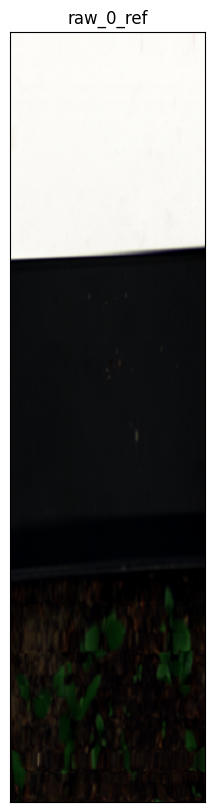

In [4]:
# Plot an RGB image of the hyperspectral image
# make the RGB image from the hyperspectral image (select RGB bands and applying stretch)
RGB_image = msf.make_rgb(im.Arr, wl, stretch = [2,98])
# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));

# Part 2: Create and save ROIs.

NOTE: To get a class probabilities image, highlight all ROIs you want to use by clicking on the 'Name' cell above all the ROI name cells, then click the 'ROI ClassProbs' button as shown below. If you highlight the full rows (instead of just the name), an error will result.

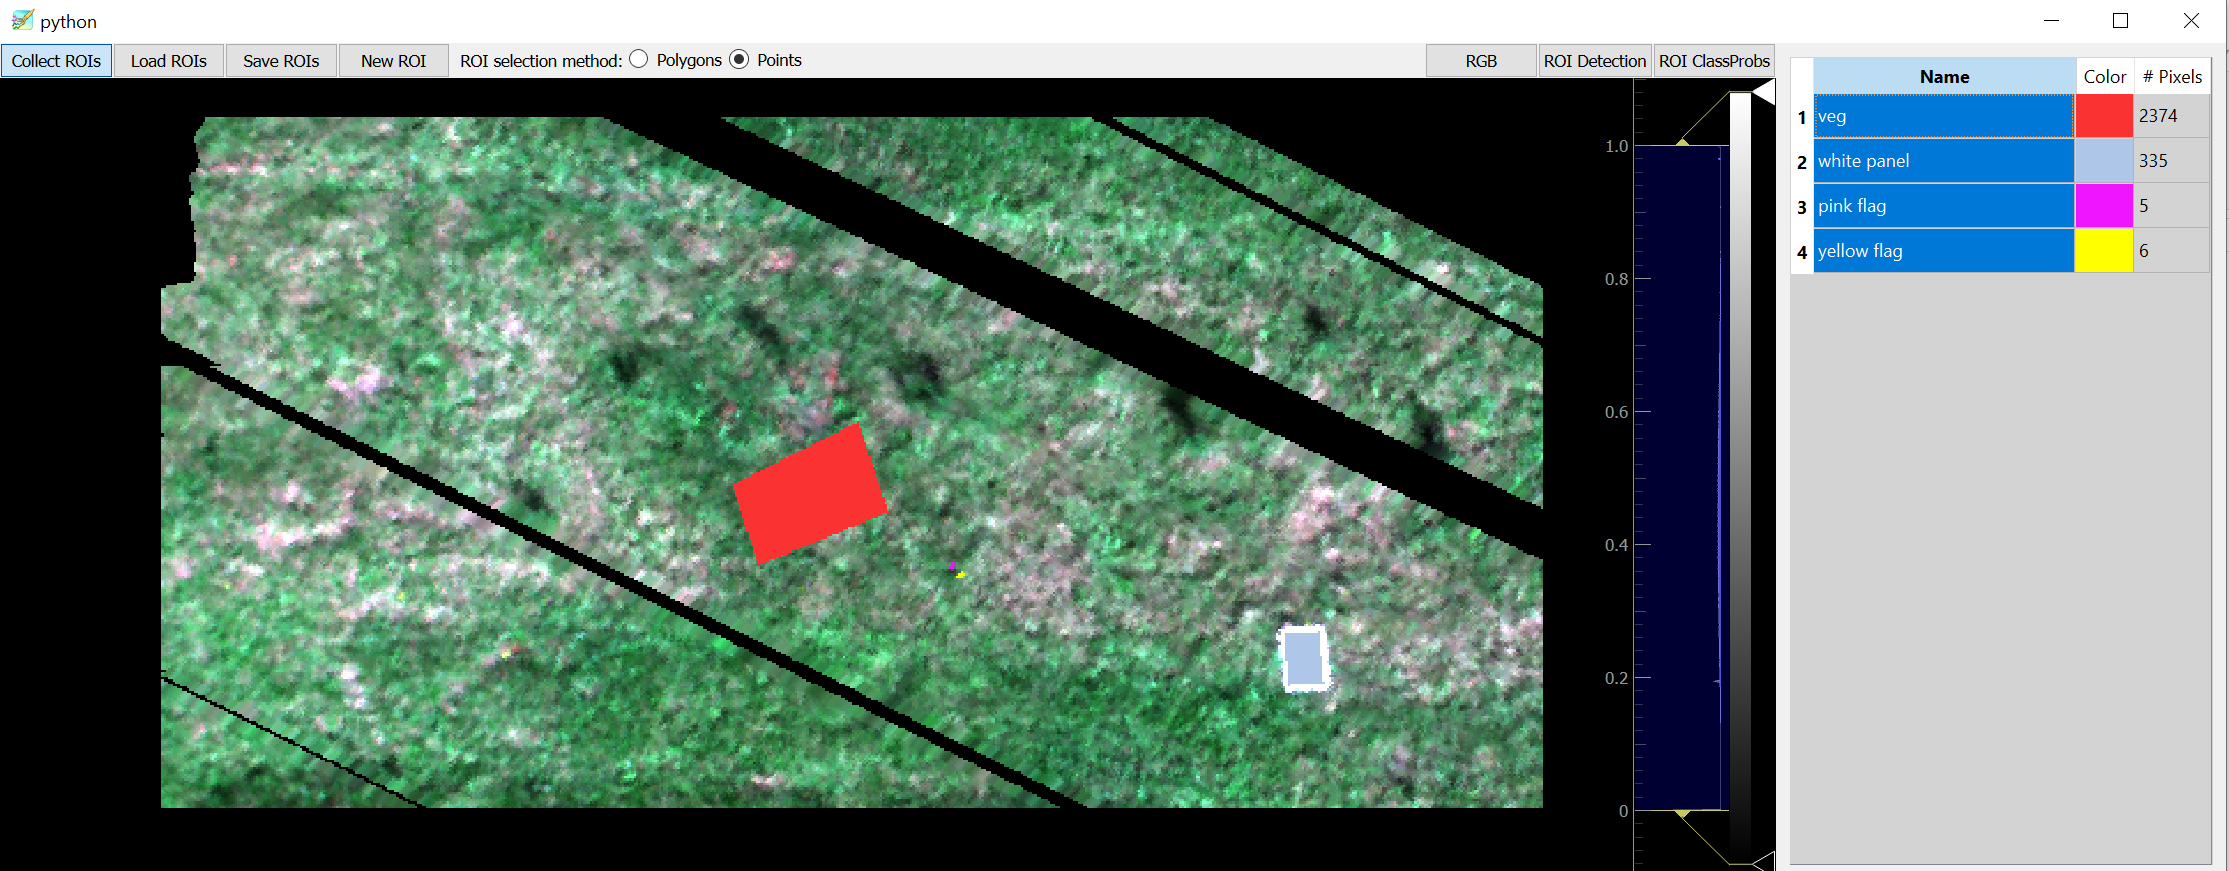

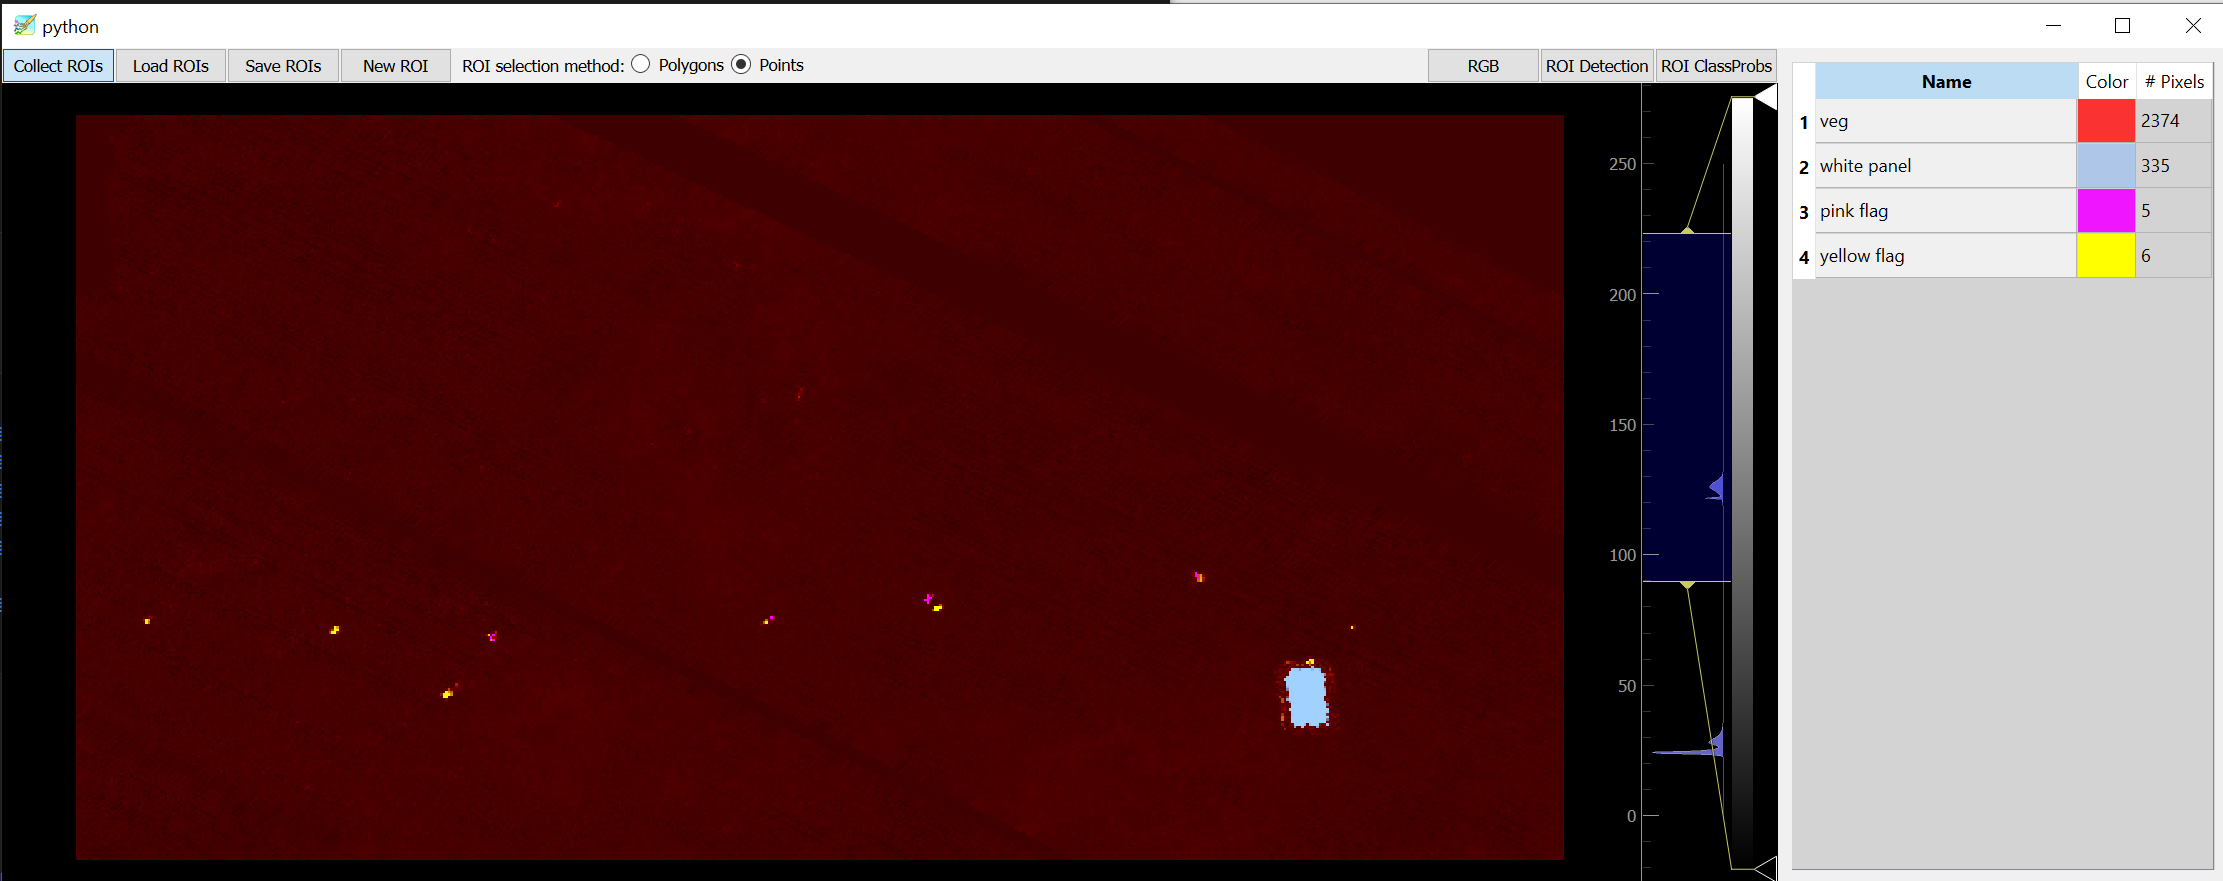

In [7]:
importlib.reload(hvr)
hvr.viewer(im, stretch=[0,99.5], rotate=True)

QLayout::addChildLayout: layout "" already has a parent


None
ROI file saved, /workspaces/UPWINS_Microscene/data/pkl/ROIs.pkl


# Part 3: Initial Evaluation of ROIs

In [8]:
# Unpickling the dictionary
#fname = 'C:\\spectral_data\\spectral_images\\UPWINS Baccharis Halimifolia.pkl'
fname = 'data/pkl/ROIs.pkl' 
with open(fname, 'rb') as f:
    roiData = pickle.load(f)

In [9]:
df = roiData.df # a DataFrame holding all the data for the ROIs
roi_names = roiData.names # the names of the ROIs
roi_colors = roiData.colors # a Python dictionary of colors, where colors[class_name] will provide the color for class class_name
roi_masks = roiData.masks # a Python dictionary of location masks, where colors[class_name] will provide the numpy array for the mask
nClasses = len(roi_names)

# Notes:
#   Each mask is an array of bollean values of the same dimensions as the image, 
#   and True represents a pixel in the ROI while False represents not in the ROI.

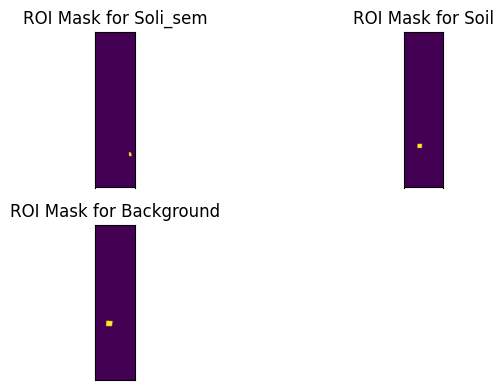

In [10]:
# determine how many rows of images (assuming each row has 2 masks)
nRowsPlots = int(np.ceil(nClasses/2)) # (change size of figure as needed)
plt.figure(figsize=(8, nRowsPlots*2))
for i in range(nClasses):
    name = roi_names[i]
    # create the subplot
    plt.subplot(nRowsPlots, 2, i+1)    
    plt.imshow(roi_masks[name])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'ROI Mask for {name}');
    plt.tight_layout()

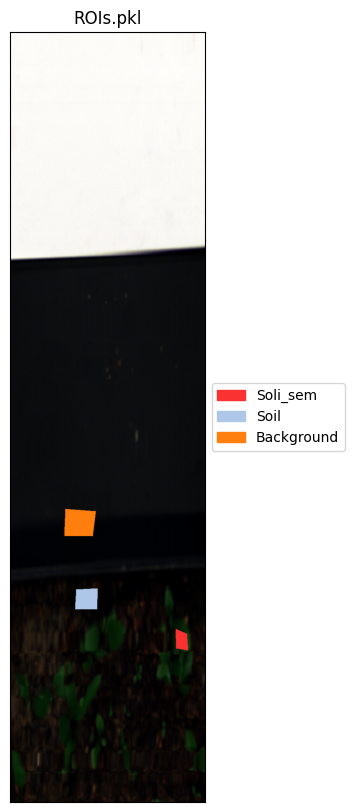

In [11]:
# Examine the locations
# create an RGB image
RGB_image_with_ROIs = msf.make_rgb(im.Arr, wl, stretch = [2,98])
# Add the ROI locations
for name in roi_names:
    # get the color for this ROI, converted from hex to (r,g,b)
    color = colors.to_rgb(roi_colors[name])
    mask = roi_masks[name]
    # set the pixel values for this ROI to (0,0,0)
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i]*(mask==False)
    # set the pixel values for this ROI to the color for this ROI
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i] + mask*color[i]

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image_with_ROIs)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));
# Create legend patches: each patch is a colored box with the ROI name.
legend_patches = [mpatches.Patch(color=roi_colors[name], label=name) for name in roi_names]
# Add the legend to the right of the image
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))


In [12]:
# Examine the dataframe
df

,Name,Color,Pixel_x,Pixel_y,399.606453,401.827297,404.04814,406.268984,408.489827,410.710671,...,981.467464,983.688307,985.909151,988.129994,990.350838,992.571681,994.792525,997.013368,999.234212,1001.455055
0,Soli_sem,#fa3232,1549,429,0.012250,-0.050967,0.108857,0.097727,0.109796,-0.008968,...,0.299516,0.272623,0.291172,0.284914,0.299789,0.288951,0.295179,0.312537,0.298670,0.361600
1,Soli_sem,#fa3232,1550,429,0.146707,0.098894,0.100213,0.067216,0.043556,0.034982,...,0.287091,0.249073,0.286776,0.310389,0.316420,0.293885,0.266430,0.309812,0.309860,0.320634
2,Soli_sem,#fa3232,1551,429,-0.021364,0.080161,0.013774,0.006192,0.070052,-0.008968,...,0.295375,0.296172,0.275787,0.282598,0.311668,0.301286,0.289952,0.290736,0.284682,0.308930
3,Soli_sem,#fa3232,1552,429,-0.077388,0.061429,0.022418,0.105355,0.036932,-0.015246,...,0.266382,0.315440,0.269194,0.273334,0.285533,0.328424,0.300407,0.263485,0.290277,0.297225
4,Soli_sem,#fa3232,1553,429,0.023454,0.052062,0.048350,0.120611,0.076676,0.053817,...,0.297445,0.304735,0.271392,0.282598,0.302165,0.279082,0.282112,0.296187,0.301467,0.311856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,Background,#ff7f0e,1248,221,0.230646,0.030596,0.224498,0.110013,0.129915,0.036573,...,0.078743,0.071068,0.090011,0.073166,0.079679,0.073124,0.095641,0.059199,0.085684,0.080499
5181,Background,#ff7f0e,1249,221,0.142253,0.082183,0.153440,0.070750,0.105829,0.081094,...,0.084417,0.082800,0.083802,0.064811,0.088490,0.070774,0.057329,0.069195,0.067376,0.066890
5182,Background,#ff7f0e,1250,221,0.283682,0.099379,0.203181,0.083838,0.123894,0.097790,...,0.093874,0.086711,0.085871,0.064811,0.044438,0.035529,0.081274,0.081690,0.059530,0.045116
5183,Background,#ff7f0e,1251,221,0.106896,0.056389,0.110805,0.129645,0.087765,0.069964,...,0.071177,0.084756,0.090011,0.083611,0.059856,0.061375,0.071696,0.066696,0.075222,0.077777
